In [3]:
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [74]:
#######################
# Heading parameters. #
# Strong order proxy. #
#######################

solver_name = "EKF0"
problem_name = "FHN"
prefix = f"{solver_name}_{problem_name}"
folder = "./EKF0_FHN"

deltas = 1/jnp.array([16, 32, 64, 128, 256, 512, 1024])
deltas = 1/jnp.array([1024])
Ns = 1/deltas
fineN = Ns**1.0
Mdeltas = jnp.ones((len(deltas),)) * (Ns)**0
T = 1.0
Ndeltas = T/deltas

for n in range(len(Ndeltas)):
    delta = deltas[n]
    N = int(Ndeltas[n])
    M = int(Mdeltas[n])
    fine = int(fineN[n])
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}_{fine}.npy')
    N = int(N)
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, T, N)
    ranged = range(N)
    plt.plot(ts, jnp.log(jnp.mean(jnp.linalg.norm(paths_1 - paths_2, axis=-1), axis=0)) / jnp.log(delta),
             label=f'delta={delta}, M={M}')
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: './EKF0_FHN/EKF0_FHN_pathwise_sols_1024_1.npy'

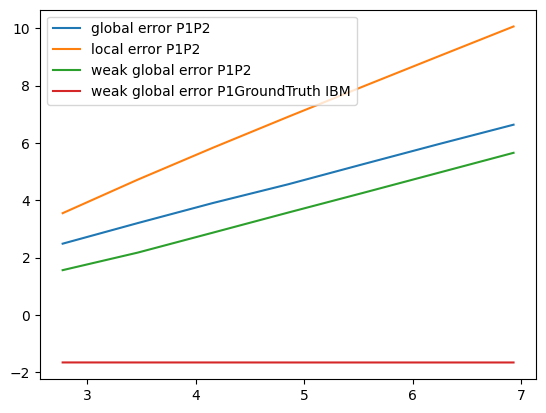

In [20]:
###########################
# Weak and global errors  #
# With log-log regression.#
###########################

STRONG_GLOBAL_ERRORS_P1P2 = []
STRONG_LOCAL_ERRORS_P1P2 = []
WEAK_GLOBAL_ERRORS_P1P2 = []
WEAK_GLOBAL_ERRORS_P1GroundTruth = []
@partial(jnp.vectorize, signature="(d,x)->(d,d)")
def WEAK_POLYNOMIAL(x):
    return x @ x.T


COV_HYPOELLIPTIC_COMPONENT_ERRORS = []
for n in range(len(deltas)):
    N = int(Ndeltas[n])
    M = int(Mdeltas[n])
    fine = int(fineN[n])
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}_{fine}.npy')
    #paths = jnp.load(f'{folder}/{prefix}_paths_{N}_{fine}.npy')
    STRONG_GLOBAL_ERROR_P1P2 = jnp.mean(jnp.linalg.norm(paths_2 - paths_1, axis=-1), axis=0)[-1]
    STRONG_LOCAL_ERROR_P1P2 = jnp.mean(jnp.linalg.norm(paths_2[:, 1] - paths_1[:, 1], axis=-1), axis=0)
    
    MOMENT_P1 = WEAK_POLYNOMIAL(paths_1[...,jnp.newaxis])
    MOMENT_P2 = WEAK_POLYNOMIAL(paths_2[...,jnp.newaxis])
    
    WEAK_GLOBAL_ERROR_P1P2 = jnp.max(jnp.linalg.norm(jnp.linalg.norm(jnp.mean(MOMENT_P2, axis=0)-jnp.mean(MOMENT_P1, axis=0),axis=-1),axis=-1),axis=-1)
    STRONG_GLOBAL_ERRORS_P1P2.append(STRONG_GLOBAL_ERROR_P1P2)
    STRONG_LOCAL_ERRORS_P1P2.append(STRONG_LOCAL_ERROR_P1P2)
    WEAK_GLOBAL_ERRORS_P1P2.append(WEAK_GLOBAL_ERROR_P1P2)
    
    #ONLY FOR IBM
    WEAK_GLOBAL_ERROR_P1GroundTruth = jnp.linalg.norm(jnp.linalg.norm(jnp.mean(MOMENT_P1[:,-1,:], axis=0)-jnp.array([[4+1/3, 2+1/2],                                                            [2+1/2, 1+1]]),axis=-1),axis=-1)
    WEAK_GLOBAL_ERRORS_P1GroundTruth.append(WEAK_GLOBAL_ERROR_P1GroundTruth)
STRONG_GLOBAL_ERRORS_P1P2 = jnp.array(STRONG_GLOBAL_ERRORS_P1P2)
STRONG_LOCAL_ERRORS_P1P2 = jnp.array(STRONG_LOCAL_ERRORS_P1P2)
WEAK_GLOBAL_ERRORS_P1P2 = jnp.array(WEAK_GLOBAL_ERRORS_P1P2)
WEAK_GLOBAL_ERRORS_P1GroundTruth = jnp.array(WEAK_GLOBAL_ERRORS_P1GroundTruth)
plt.plot(-jnp.log(deltas), -jnp.log(STRONG_GLOBAL_ERRORS_P1P2), label='global error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(STRONG_LOCAL_ERRORS_P1P2), label='local error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(WEAK_GLOBAL_ERRORS_P1P2), label='weak global error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth), label='weak global error P1GroundTruth IBM')
plt.legend()

linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_GLOBAL_ERRORS_P1P2))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_LOCAL_ERRORS_P1P2))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(WEAK_GLOBAL_ERRORS_P1P2))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas)[:-4].reshape(-1, 1), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth[:-4]))
print(linear_regressor.coef_)

In [22]:

jnp.save(f'{prefix}_STRONG_GLOBAL_ERRORS', jnp.array([deltas, STRONG_GLOBAL_ERRORS_P1P2]))
jnp.save(f'{prefix}_STRONG_LOCAL_ERRORS', jnp.array([deltas, STRONG_LOCAL_ERRORS_P1P2]))
jnp.save(f'{prefix}_WEAK_GLOBAL_ERRORS', jnp.array([deltas, WEAK_GLOBAL_ERRORS_P1P2]))
#jnp.save(f'{prefix}_WEAK_GLOBAL_ERRORS_P1GroundTruth', jnp.array([deltas, WEAK_GLOBAL_ERRORS_P1GroundTruth]))

In [23]:
STRONG_GLOBAL_ERRORS = jnp.load(f'{prefix}_STRONG_GLOBAL_ERRORS.npy')
STRONG_LOCAL_ERRORS = jnp.load(f'{prefix}_STRONG_LOCAL_ERRORS.npy')
WEAK_GLOBAL_ERRORS = jnp.load(f'{prefix}_WEAK_GLOBAL_ERRORS.npy')
#WEAK_GLOBAL_ERRORS_P1GroundTruth = jnp.load(f'{prefix}_WEAK_GLOBAL_ERRORS_P1GroundTruth.npy')

np.savetxt(f'{prefix}_STRONG_GLOBAL_ERRORS.csv', STRONG_GLOBAL_ERRORS.T, delimiter=',', header='deltas,errors', comments="")
np.savetxt(f'{prefix}_STRONG_LOCAL_ERRORS.csv', STRONG_LOCAL_ERRORS.T, delimiter=',', header='deltas,errors', comments="")
np.savetxt(f'{prefix}_WEAK_GLOBAL_ERRORS.csv', WEAK_GLOBAL_ERRORS.T, delimiter=',', header='deltas,errors', comments="")
#np.savetxt(f'{prefix}_WEAK_GLOBAL_ERRORS_P1GroundTruth.csv', WEAK_GLOBAL_ERRORS_P1GroundTruth.T, delimiter=',', header='deltas,errors', comments="")

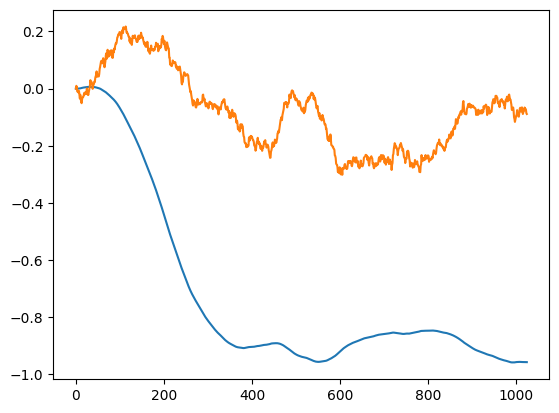

In [9]:
###############
# Sample path #
###############

plt.plot(paths_1[10]) # Approximation
plt.plot(paths_2[10]) # Fine solution.

In [176]:
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth))
print(linear_regressor.coef_)

[0.9219163]


In [90]:
ts = jnp.insert(jnp.linspace(1/1024, 1, 1024),0,0)
np.savetxt(f'{prefix}_correct_mean_first.csv', jnp.array([ts, jnp.mean(paths_2[:,:,0], axis=0)]).T, delimiter=',', header='t,mean', comments="")
np.savetxt(f'{prefix}_correct_mean_secnd.csv', jnp.array([ts, jnp.mean(paths_2[:,:,1], axis=0)]).T, delimiter=',', header='t,mean', comments="")
np.savetxt(f'{prefix}_incorrect_mean_first.csv', jnp.array([ts, jnp.mean(paths_1[:,:,0], axis=0)]).T, delimiter=',', header='t,mean', comments="")
np.savetxt(f'{prefix}_incorrect_mean_secnd.csv', jnp.array([ts, jnp.mean(paths_1[:,:,1], axis=0)]).T, delimiter=',', header='t,mean', comments="")

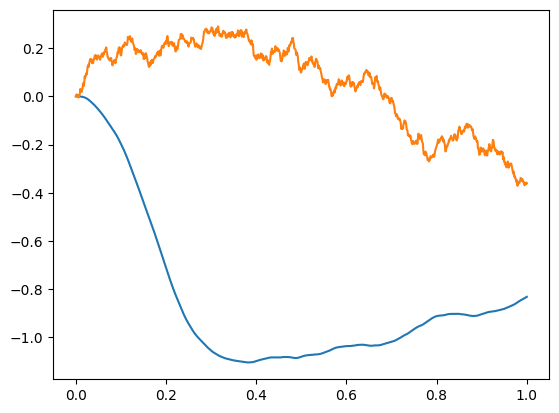

In [11]:
plt.plot(ts, paths_2[0,:,0], label='correct mean first')
plt.plot(ts, paths_2[0,:,1], label='correct mean second')

In [13]:
np.savetxt(f'{prefix}_path_0.csv', jnp.array([ts, paths_2[0,:,0]]).T, delimiter=',', header='t,mean', comments="")
np.savetxt(f'{prefix}_path_1.csv', jnp.array([ts, paths_2[0,:,1]]).T, delimiter=',', header='t,mean', comments="")

In [129]:
import pandas as pd

solver_name = "EKF0_SSM"
problem_name = "FHN"
prefix = f"{solver_name}_{problem_name}"
folder = "./EKF0_FHN"

print(prefix)
#res_global_error = pd.read_csv(f'{folder}/{prefix}_STRONG_GLOBAL_ERRORS.csv', index_col=False, header=0)
#res_local_error = pd.read_csv(f'{folder}/{prefix}_STRONG_LOCAL_ERRORS.csv', index_col=False, header=0)
res_weak_error = pd.read_csv(f'{folder}/{prefix}_WEAK_GLOBAL_ERRORS.csv', index_col=False, header=0)



EKF0_SSM_FHN


In [130]:
def summary(df):
    regr = LinearRegression()
    X = jnp.log(df.deltas.values).reshape(6, 1)
    Y = jnp.log(df.errors.values).reshape(6,1)
    regr.fit(X, Y)
    var_ = jnp.sqrt(1/4*jnp.sum((regr.predict(X)-Y)**2,axis=0))
    return regr.coef_, regr.intercept_, var_, regr.score(X, Y)
#print('STRONG LOCAL')
#print(summary(res_local_error))
#print('STRONG GLOBAL')
#print(summary(res_global_error))
print('WEAK GLOBAL')
print(summary(res_weak_error))

WEAK GLOBAL
(array([[0.69361734]], dtype=float32), array([-1.2872899], dtype=float32), Array([0.35014224], dtype=float32), 0.8918754439239495)


In [131]:
def tabular(df1, df2, df3):
    a1, b1, sigma1, R21 = summary(df1)
    a2, b2, sigma2, R22 = summary(df2)
    a3, b3, sigma3, R23 = summary(df3)
    str=f'''
             ${a1[0,0]}$ & ${b1[0]}$ & ${sigma1[0]}$ & ${R21}$\\
             ${a2[0,0]}$ & ${b2[0]}$ & ${sigma2[0]}$ & ${R22}$\\
             ${a3[0,0]}$ & ${b3[0]}$ & ${sigma3[0]}$ & ${R23}$\\
    '''
    return str

In [106]:
tabular(res_local_error, res_global_error, res_weak_error)

'\n             $1.5075632333755493$ & $1.0855951309204102$ & $3.1117751598358154$ & $0.9999898953042612$\\\n             $0.9370822310447693$ & $0.569094181060791$ & $0.03409314900636673$ & $0.9993706728203372$\\\n             $1.6154711246490479$ & $1.4093098640441895$ & $3.434255599975586$ & $0.9888400756220493$\\\n    '

In [86]:
summary(res_local_error)

[[1.522764]]
[-0.17104483]
[3.103445]
0.9999364609415841
